# Bayesian Neural Network (VI) for regression

### Zhenwen Dai (2018-8-21)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import mxfusion as mf
import mxnet as mx
import numpy as np
import mxnet.gluon.nn as nn
import mxfusion.components
import mxfusion.inference

### Generate Synthetic Data

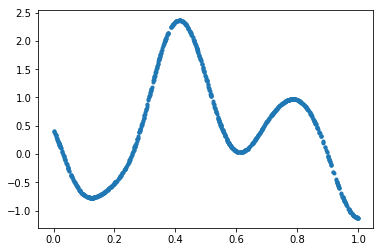

In [2]:
import GPy
%matplotlib inline
from pylab import *

k = GPy.kern.RBF(1, lengthscale=0.1)
x = np.random.rand(1000,1)
y = np.random.multivariate_normal(mean=np.zeros((1000,)), cov=k.K(x), size=(1,)).T
plot(x[:,0], y[:,0], '.')

## Model definition

In [3]:
D = 50
net = nn.HybridSequential(prefix='nn_')
with net.name_scope():
    net.add(nn.Dense(D, activation="tanh"))
    net.add(nn.Dense(D, activation="tanh"))
    net.add(nn.Dense(1, flatten=True))
net.initialize(mx.init.Xavier(magnitude=3))
_=net(mx.nd.array(x))

In [4]:
from mxfusion.components.variables.var_trans import PositiveTransformation
from mxfusion.inference import VariationalPosteriorForwardSampling

In [5]:
m = mf.Model()
m.N = mf.Variable()
m.f = mf.functions.MXFusionGluonFunction(net, num_outputs=1,broadcastable=False)
m.x = mf.Variable(shape=(m.N,1))
m.v = mf.Variable(shape=(1,), transformation=PositiveTransformation(), initial_value=mx.nd.array([0.01]))
#m.prior_variance = mf.core.Variable(shape=(1,), transformation=PositiveTransformation())
m.r = m.f(m.x)
for _,v in m.r.factor.block_variables:
    v.set_prior(mf.components.distributions.Normal(mean=mx.nd.array([0]),variance=mx.nd.array([1.])))
m.y = mf.distributions.Normal.define_variable(mean=m.r, variance=m.v, shape=(m.N,1))
print(m)

Variable(16efc) ~ Normal(mean=Variable(e0918), variance=Variable(1aac8))
Variable(37163) ~ Normal(mean=Variable(b0769), variance=Variable(53e52))
Variable(af8b9) ~ Normal(mean=Variable(966fe), variance=Variable(bc3dd))
Variable(7aeb4) ~ Normal(mean=Variable(d7939), variance=Variable(74c6b))
Variable(16f77) ~ Normal(mean=Variable(d7136), variance=Variable(e237b))
Variable(e5ac8) ~ Normal(mean=Variable(132d2), variance=Variable(9806f))
r = GluonFunctionEvaluation(nn_dense0_weight=Variable(e5ac8), nn_dense0_bias=Variable(16f77), nn_dense1_weight=Variable(7aeb4), nn_dense1_bias=Variable(af8b9), nn_dense2_weight=Variable(37163), nn_dense2_bias=Variable(16efc), nn_input_0=x)
y ~ Normal(mean=r, variance=v)


## Inference with Meanfield

In [6]:
from mxfusion.inference import BatchInferenceLoop, create_Gaussian_meanfield, GradBasedInference, StochasticVariationalInference

In [7]:
observed = [m.y, m.x]
q = create_Gaussian_meanfield(model=m, observed=observed)
alg = StochasticVariationalInference(num_samples=3, model=m, posterior=q, observed=observed)
infr = GradBasedInference(inference_algorithm=alg, grad_loop=BatchInferenceLoop())

In [8]:
infr.initialize(y=mx.nd.array(y), x=mx.nd.array(x))

In [9]:
for v_name, v in m.r.factor.block_variables:
    uuid = v.uuid
    loc_uuid = infr.inference_algorithm.posterior[uuid].factor.variance.uuid
    a = infr.params.param_dict[loc_uuid].data().asnumpy()
    a[:] = 1e-6
    infr.params[infr.inference_algorithm.posterior[uuid].factor.mean] = net.collect_params()[v_name].data()
    infr.params[infr.inference_algorithm.posterior[uuid].factor.variance] = mx.nd.array(a)

In [10]:
infr.run(max_iter=2000, learning_rate=1e-2, y=mx.nd.array(y), x=mx.nd.array(x), verbose=True)

Iteration 1 logL: -18937.779296875
Iteration 2 logL: -18657.76171875
Iteration 3 logL: -18782.6328125
Iteration 4 logL: -18741.7734375
Iteration 5 logL: -18650.27734375
Iteration 6 logL: -18619.716796875
Iteration 7 logL: -18628.115234375
Iteration 8 logL: -18626.595703125
Iteration 9 logL: -18599.216796875
Iteration 10 logL: -18563.693359375
Iteration 11 logL: -18522.083984375
Iteration 12 logL: -18529.48046875
Iteration 13 logL: -18509.841796875
Iteration 14 logL: -18522.365234375
Iteration 15 logL: -18491.373046875
Iteration 16 logL: -18508.052734375
Iteration 17 logL: -18494.8046875
Iteration 18 logL: -18427.91796875
Iteration 19 logL: -18384.19140625
Iteration 20 logL: -18435.3046875
Iteration 21 logL: -18418.203125
Iteration 22 logL: -18364.93359375
Iteration 23 logL: -18349.78515625
Iteration 24 logL: -18360.291015625
Iteration 25 logL: -18352.4140625
Iteration 26 logL: -18340.515625
Iteration 27 logL: -18295.341796875
Iteration 28 logL: -18316.798828125
Iteration 29 logL: -1828

Iteration 236 logL: -14826.6103515625
Iteration 237 logL: -14807.236328125
Iteration 238 logL: -14822.0732421875
Iteration 239 logL: -14806.689453125
Iteration 240 logL: -14752.328125
Iteration 241 logL: -14788.466796875
Iteration 242 logL: -14749.5966796875
Iteration 243 logL: -14734.001953125
Iteration 244 logL: -14695.5654296875
Iteration 245 logL: -14664.875
Iteration 246 logL: -14703.6220703125
Iteration 247 logL: -14674.4345703125
Iteration 248 logL: -14615.3017578125
Iteration 249 logL: -14647.806640625
Iteration 250 logL: -14635.33203125
Iteration 251 logL: -14639.46875
Iteration 252 logL: -14606.501953125
Iteration 253 logL: -14574.6640625
Iteration 254 logL: -14586.6416015625
Iteration 255 logL: -14563.791015625
Iteration 256 logL: -14544.630859375
Iteration 257 logL: -14511.8212890625
Iteration 258 logL: -14524.94140625
Iteration 259 logL: -14516.712890625
Iteration 260 logL: -14486.732421875
Iteration 261 logL: -14455.013671875
Iteration 262 logL: -14480.568359375
Iteration

Iteration 464 logL: -11087.8046875
Iteration 465 logL: -11078.876953125
Iteration 466 logL: -11108.6591796875
Iteration 467 logL: -11119.771484375
Iteration 468 logL: -10991.5390625
Iteration 469 logL: -11277.0556640625
Iteration 470 logL: -10988.1953125
Iteration 471 logL: -11047.580078125
Iteration 472 logL: -10963.279296875
Iteration 473 logL: -10991.728515625
Iteration 474 logL: -10982.900390625
Iteration 475 logL: -10829.11328125
Iteration 476 logL: -10845.712890625
Iteration 477 logL: -10789.142578125
Iteration 478 logL: -10765.857421875
Iteration 479 logL: -10790.1171875
Iteration 480 logL: -10777.98828125
Iteration 481 logL: -10658.359375
Iteration 482 logL: -10819.4912109375
Iteration 483 logL: -10704.7138671875
Iteration 484 logL: -10627.126953125
Iteration 485 logL: -10635.173828125
Iteration 486 logL: -10622.076171875
Iteration 487 logL: -10509.611328125
Iteration 488 logL: -10575.458984375
Iteration 489 logL: -10602.171875
Iteration 490 logL: -10620.505859375
Iteration 491

Iteration 696 logL: -7388.4521484375
Iteration 697 logL: -7520.9912109375
Iteration 698 logL: -7642.1337890625
Iteration 699 logL: -7268.595703125
Iteration 700 logL: -7568.1328125
Iteration 701 logL: -7336.7705078125
Iteration 702 logL: -7112.2685546875
Iteration 703 logL: -7275.10205078125
Iteration 704 logL: -7102.44677734375
Iteration 705 logL: -7241.18310546875
Iteration 706 logL: -7287.6416015625
Iteration 707 logL: -7197.6494140625
Iteration 708 logL: -7349.42431640625
Iteration 709 logL: -7291.0
Iteration 710 logL: -7544.52685546875
Iteration 711 logL: -7188.6455078125
Iteration 712 logL: -7123.98486328125
Iteration 713 logL: -7065.8212890625
Iteration 714 logL: -7282.0986328125
Iteration 715 logL: -7105.7333984375
Iteration 716 logL: -7089.1201171875
Iteration 717 logL: -7214.619140625
Iteration 718 logL: -7426.2578125
Iteration 719 logL: -7273.19091796875
Iteration 720 logL: -7445.564453125
Iteration 721 logL: -6905.1337890625
Iteration 722 logL: -7533.8671875
Iteration 723 l

Iteration 921 logL: -5218.5703125
Iteration 922 logL: -5081.14208984375
Iteration 923 logL: -4774.740234375
Iteration 924 logL: -5070.3232421875
Iteration 925 logL: -5089.40625
Iteration 926 logL: -4686.31005859375
Iteration 927 logL: -4775.6474609375
Iteration 928 logL: -4763.92578125
Iteration 929 logL: -4879.61181640625
Iteration 930 logL: -4732.5263671875
Iteration 931 logL: -4777.931640625
Iteration 932 logL: -4545.6162109375
Iteration 933 logL: -4608.525390625
Iteration 934 logL: -4720.26171875
Iteration 935 logL: -4555.771484375
Iteration 936 logL: -4784.58203125
Iteration 937 logL: -4670.37939453125
Iteration 938 logL: -4743.01025390625
Iteration 939 logL: -4522.27197265625
Iteration 940 logL: -4491.27490234375
Iteration 941 logL: -4501.4384765625
Iteration 942 logL: -4628.42236328125
Iteration 943 logL: -4450.9521484375
Iteration 944 logL: -4649.005859375
Iteration 945 logL: -4407.55908203125
Iteration 946 logL: -4426.68994140625
Iteration 947 logL: -4576.7685546875
Iteration 

Iteration 1142 logL: -3116.11181640625
Iteration 1143 logL: -2937.67626953125
Iteration 1144 logL: -2727.93701171875
Iteration 1145 logL: -2894.7353515625
Iteration 1146 logL: -3207.540771484375
Iteration 1147 logL: -3101.56884765625
Iteration 1148 logL: -3653.634521484375
Iteration 1149 logL: -3022.465576171875
Iteration 1150 logL: -3175.86279296875
Iteration 1151 logL: -3975.07568359375
Iteration 1152 logL: -2939.88232421875
Iteration 1153 logL: -3280.00244140625
Iteration 1154 logL: -3134.5283203125
Iteration 1155 logL: -3913.14501953125
Iteration 1156 logL: -3457.078125
Iteration 1157 logL: -2795.12353515625
Iteration 1158 logL: -3158.18115234375
Iteration 1159 logL: -4433.541015625
Iteration 1160 logL: -3068.809326171875
Iteration 1161 logL: -2757.013427734375
Iteration 1162 logL: -3219.167724609375
Iteration 1163 logL: -3885.333740234375
Iteration 1164 logL: -3355.156982421875
Iteration 1165 logL: -2883.091796875
Iteration 1166 logL: -3027.73291015625
Iteration 1167 logL: -2868.9

Iteration 1358 logL: -2335.33544921875
Iteration 1359 logL: -2181.8291015625
Iteration 1360 logL: -2131.503662109375
Iteration 1361 logL: -1949.7342529296875
Iteration 1362 logL: -2105.894775390625
Iteration 1363 logL: -2014.6802978515625
Iteration 1364 logL: -1953.83837890625
Iteration 1365 logL: -2201.7197265625
Iteration 1366 logL: -2032.163818359375
Iteration 1367 logL: -1998.925048828125
Iteration 1368 logL: -2712.530029296875
Iteration 1369 logL: -1966.589599609375
Iteration 1370 logL: -2078.01708984375
Iteration 1371 logL: -1835.460693359375
Iteration 1372 logL: -1974.9193115234375
Iteration 1373 logL: -1983.134521484375
Iteration 1374 logL: -2251.118896484375
Iteration 1375 logL: -1809.73095703125
Iteration 1376 logL: -1825.0743408203125
Iteration 1377 logL: -1776.5494384765625
Iteration 1378 logL: -1834.92919921875
Iteration 1379 logL: -1780.156494140625
Iteration 1380 logL: -1772.369873046875
Iteration 1381 logL: -1979.2255859375
Iteration 1382 logL: -1803.81689453125
Iterati

Iteration 1568 logL: -1699.322021484375
Iteration 1569 logL: -1448.417724609375
Iteration 1570 logL: -1686.6485595703125
Iteration 1571 logL: -2144.88134765625
Iteration 1572 logL: -1421.5628662109375
Iteration 1573 logL: -1439.463623046875
Iteration 1574 logL: -1831.92919921875
Iteration 1575 logL: -1466.885009765625
Iteration 1576 logL: -1635.5579833984375
Iteration 1577 logL: -1435.766357421875
Iteration 1578 logL: -1822.155029296875
Iteration 1579 logL: -1681.8177490234375
Iteration 1580 logL: -1559.178466796875
Iteration 1581 logL: -1540.3330078125
Iteration 1582 logL: -1531.673095703125
Iteration 1583 logL: -1697.203857421875
Iteration 1584 logL: -1600.952392578125
Iteration 1585 logL: -1443.25341796875
Iteration 1586 logL: -1522.170166015625
Iteration 1587 logL: -1519.8377685546875
Iteration 1588 logL: -1294.329345703125
Iteration 1589 logL: -1392.041748046875
Iteration 1590 logL: -1300.7552490234375
Iteration 1591 logL: -1376.3773193359375
Iteration 1592 logL: -1631.87255859375

Iteration 1776 logL: -960.9752197265625
Iteration 1777 logL: -1310.44287109375
Iteration 1778 logL: -1674.1209716796875
Iteration 1779 logL: -1529.165283203125
Iteration 1780 logL: -1040.686767578125
Iteration 1781 logL: -1202.1591796875
Iteration 1782 logL: -1537.99365234375
Iteration 1783 logL: -1631.1114501953125
Iteration 1784 logL: -1238.438232421875
Iteration 1785 logL: -1870.7489013671875
Iteration 1786 logL: -1909.86767578125
Iteration 1787 logL: -1169.7144775390625
Iteration 1788 logL: -1647.84326171875
Iteration 1789 logL: -1441.4766845703125
Iteration 1790 logL: -1550.7138671875
Iteration 1791 logL: -1346.6708984375
Iteration 1792 logL: -1327.56982421875
Iteration 1793 logL: -1383.95654296875
Iteration 1794 logL: -1426.2900390625
Iteration 1795 logL: -1513.406982421875
Iteration 1796 logL: -970.977783203125
Iteration 1797 logL: -1367.77099609375
Iteration 1798 logL: -1099.1207275390625
Iteration 1799 logL: -1230.522216796875
Iteration 1800 logL: -1260.0513916015625
Iteration

Iteration 1982 logL: -1238.0399169921875
Iteration 1983 logL: -902.128662109375
Iteration 1984 logL: -1011.17041015625
Iteration 1985 logL: -780.9232177734375
Iteration 1986 logL: -1055.0699462890625
Iteration 1987 logL: -931.285400390625
Iteration 1988 logL: -1155.91552734375
Iteration 1989 logL: -1398.5006103515625
Iteration 1990 logL: -1660.46826171875
Iteration 1991 logL: -1018.411865234375
Iteration 1992 logL: -1086.9796142578125
Iteration 1993 logL: -1079.489501953125
Iteration 1994 logL: -1012.3404541015625
Iteration 1995 logL: -1172.052734375
Iteration 1996 logL: -1050.1905517578125
Iteration 1997 logL: -1175.0185546875
Iteration 1998 logL: -923.380126953125
Iteration 1999 logL: -872.8800048828125
Iteration 2000 logL: -2102.41259765625


## Use prediction to visualize the resulting BNN

In [11]:
xt = np.linspace(0,1,100)[:,None]

In [12]:
infr2 = VariationalPosteriorForwardSampling(10, [m.x], infr, [m.r])
res = infr2.run(x=mx.nd.array(xt))

In [13]:
yt = res[m.r].asnumpy()

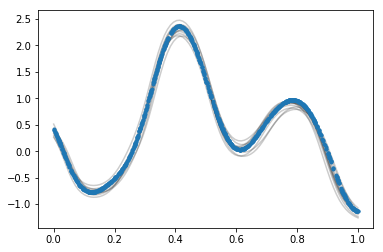

In [14]:
yt_mean = yt.mean(0)
yt_std = yt.std(0)

for i in range(yt.shape[0]):
    plot(xt[:,0],yt[i,:,0],'k',alpha=0.2)
plot(x[:,0],y[:,0],'.')